In [68]:
import numpy as np
from numba import njit, jit, vectorize, float64, prange
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sys
from os.path import exists
from scipy import stats

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [4]:
def confidence_intervals(sample_variances, p):
    """
    Returns the 100(1-p)% confidence intervals
    sample_variances    ----------
    sample_variances: array
        array of sample variances
    
    p: float between 0 and 1 exclusive
        p-value for confidence interval
        
    Returns
    -------
    intervals: array of floats
        |x - μ| < intervals, where X is the sample mean
        
    Notes
    -----
    Calculated as
        `stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)`
    where n = `len(sample_variances)`
    """
    n = len(sample_variances)
    intervals = stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)
    return intervals

In [22]:
@njit
def random_uniform(low = 0.0, high = 1.0, size = 1, seed = 0):
    if (seed):
        np.random.seed(seed)
        
    randos = np.random.random(size = size)
    scale = np.abs(high - low)
    randos *= scale
    randos += low
    return randos

@njit
def random_uniform_orthogonal(nax, l_bounds, u_bounds, seed = 0):
    """
    TODO: license
    TODO: docstring
    TODO: seeding?
    """
    if (seed):
        np.random.seed(seed)
        
    N = np.power(nax, 2)
    x_scale = (u_bounds[0] - l_bounds[0])/N
    y_scale = (u_bounds[1] - l_bounds[1])/N
    x0 = l_bounds[0]
    y0 = l_bounds[1]
    xlist = np.arange(N).reshape((nax,nax))
    ylist = np.arange(N).reshape((nax,nax))
    x_randos = np.empty(N, dtype = np.float64)
    y_randos = np.empty(N, dtype = np.float64)
    for i in range(nax):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    for i in range(nax):
        for j in range(nax):
            x_randos[i*nax + j] = x0 + x_scale * (xlist[i][j] + (np.random.random()))
            y_randos[i*nax + j] = y0 + y_scale * (ylist[j][i] + (np.random.random()))
    return x_randos, y_randos

In [23]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.empty(len(samples), dtype = np.int64)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

@njit
def create_batch_uniform(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    samples_re = random_uniform(low = re_low, high = re_high, size = N)
    samples_im = random_uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

@njit
def create_batch_orthogonal(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    nax = np.int64(np.ceil(np.sqrt(N)))
    l_bounds = (re_low, im_low)
    u_bounds = (re_high, im_high)
    samples_re, samples_im = random_uniform_orthogonal(nax, l_bounds, u_bounds)
    samples = samples_re + 1j*samples_im
    np.random.shuffle(samples)
    samples = samples[:N]
    return samples

def create_batch_lhc(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.LatinHypercube(d = 2, seed = seed)
    else:
        sampler = stats.qmc.LatinHypercube(d = 2)
    re_scale = re_high - re_low
    im_scale = im_high - im_low
    samples = sampler.random(N)
    samples[:,0] *= re_scale
    samples[:,1] *= im_scale
    samples[:,0] += re_low
    samples[:,1] += im_low
    samples = samples[:,0] + 1j*samples[:,1]
    return samples

@njit
def genrand_uniform(low = 0.0, high = 1.0, size = 1, sampler = random_uniform):
    return sampler(low, high, size)

In [21]:
@jit(nopython = True)
def set_count_from_iter_counts(max_iter, iter_counts):
    set_count = 0
    for count in iter_counts:
        if count == max_iter - 1:
            set_count += 1
    return set_count

@jit(nopython = True)
def area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, max_iter):
    n = len(iter_counts)
    set_count = set_count_from_iter_counts(max_iter, iter_counts)
    domain_area = (re_high - re_low) * (im_high - im_low)
    return domain_area * set_count / n

In [6]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples):
    """
    Counts the number of complex numbers in `samples` that do
    not meet the escape condition in `max_iter` recursions of
    the Mandelbrot polynomial, z(n+1) = z(n)^2 + c
    
    The escape condition used is |z(n)| >= 2
    
    Parameters
    ----------
    max_iter: positive integer
        Value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        values of z(0)
        
    Returns
    -------
    set_count: positive integer
        Number of complex numbers in `samples` that remain
        that do not satisfy the escape condition
    """
    set_count = 0
    for i in prange(len(samples)):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                break
            elif j == max_iter - 1:
                set_count += 1
    return set_count

@jit(nopython = True, nogil = True, parallel = True)
def mandelbrot_mc_area(re_low, re_high, im_low, im_high, max_iter, samples):
    """
    Calculates estimator of the area of the Mandelbrot set
    
    Parameters
    ----------
    re_low, re_high, im_low, im_high: float or float-like
        corners of bounding rectangle in the complex plane
    
    max_iter: positive integer
        value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        list of c values, assumed to be drawn from a uniform distribution
        in the bounding region
        
    Returns
    -------
    area: default numpy float (float32 or float64)
        estimate of the area of the mandelbrot set
    """
    count = mandelbrot_mc(max_iter, samples)
    return mandelbrot_area(count, len(samples), re_low, re_high, im_low, im_high)

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    """
    TODO: Add docstring
    """
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

@jit(nopython = True)
def mandelbrot_mc_runs(max_iter, samples, runs_count):
    counts = np.zeros(runs_count)
    for _ in range(runs_count):
        counts[i] = mandelbrot_mc(max_iter, samples)
    return counts

@jit(nopython = True)
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

In [7]:
N = 10**6
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5
area = (re_high - re_low) * (im_high - im_low)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [8]:
start_time = timer()
count = mandelbrot_mc_default(i, samples)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")
print(area_from_iter_counts(re_low, re_high, im_low, im_high, count, i) * 2)

Execution time: 0.54 seconds
1.506816


In [9]:
# # [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
# N = 10**8
# # TODO: save large random arrays
# np.random.seed(10010)
# samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [10]:
# start_time = timer()
# count = mandelbrot_mc_default(i,samples)
# end_time = timer()
# print(end_time - start_time)

In [11]:
s = 10**5
i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_s.npz"

mean_areas = np.empty(len(i_values))
sample_variances = np.empty(len(i_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,i in enumerate(i_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(i_values)

In [12]:
print(mean_areas * 2)

[2.0245032 1.5460776 1.5106986 1.5087114 1.506816  1.5078708 1.5051294]


In [5]:
def compute_difference(values):
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)

In [52]:

def iteration_variance_fixed_s(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different i values and fixed s = 10^5, 
    together with the difference in means between 
    the maximum number of iterations and 
    other numbers of iterations
    
    """
    
    i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)
    
    difference = compute_difference(values = mean_areas)

    ax = plt.gca() 
    
    plt.plot(i_values, mean_areas, alpha = 0.5, marker = "h", color = "maroon")
    plt.fill_between(i_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2, color = 'brown')
    plt.xlabel("Number of iterations (i)")
    plt.ylim(0.8, 2.3)
    ax.set_ylabel("Mean approximated area A(i,s)", color = "maroon")
    ax.tick_params(axis='y', labelcolor= 'maroon')
    plt.grid(True)
    
    
    ax2 = ax.twinx()
    ax2.plot(i_values, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.6)
    for xitem, yitem in np.nditer([i_values, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor= 'black')
    ax2.set_ylabel("Difference |A(i,s) - A(j,s)|", color = 'black')
    
    ax.set_xscale('log')
    
    plt.savefig(title)
    plt.show() 

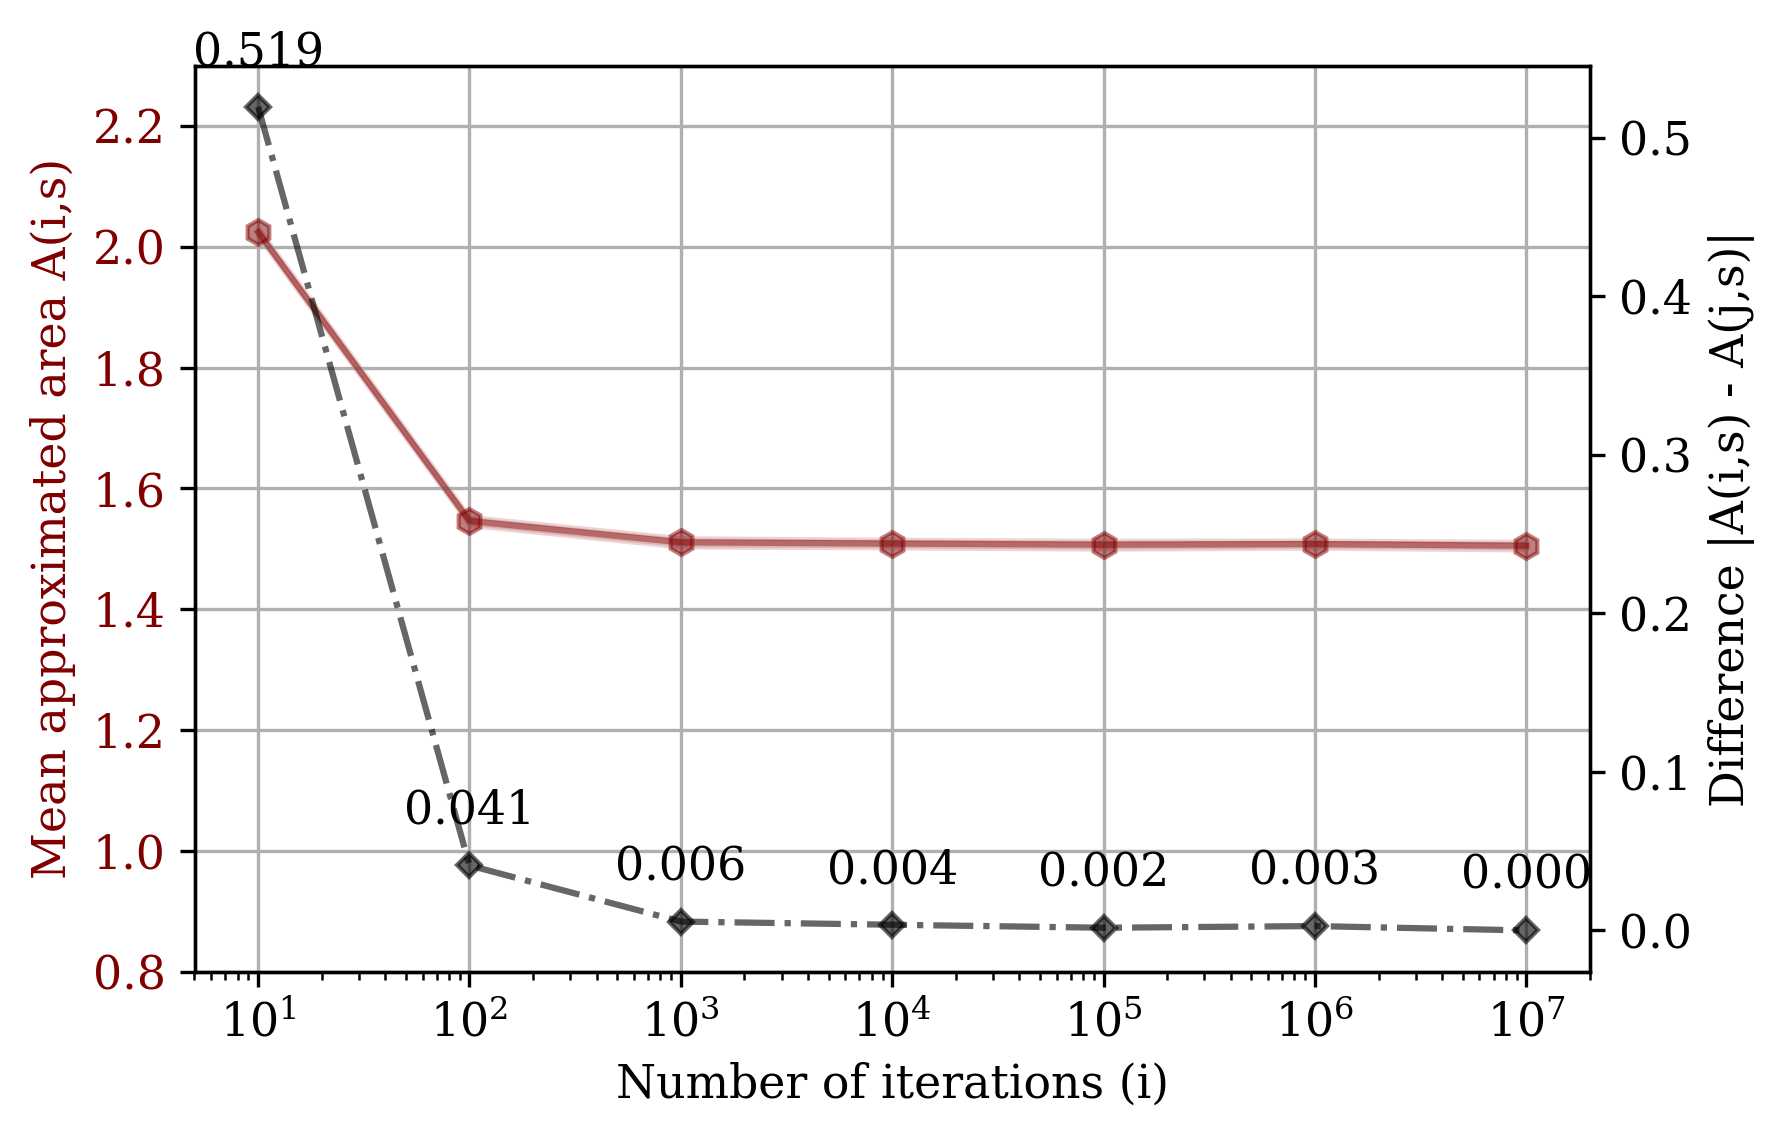

In [53]:
iteration_variance_fixed_s(simulation_data = "mc_fixed_s.npz" , title = "I_variance_s_fixed.png")

In [11]:
i = 2500
s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_i.npz"

mean_areas = np.empty(len(s_values))
sample_variances = np.empty(len(s_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,s in enumerate(s_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(s_values)

In [22]:
print(mean_areas * 2)

[1.602      1.5354     1.54296    1.51524    1.5111324  1.50780816
 1.50778742]


In [54]:
def sample_variance_fixed_i(simulation_data, title):

    """
    Plots mean appromimated area with 95% CI
    or different s values and fixed i = 2500, 
    together with the difference in 95% CI between 
    the maximum number of sample size and 
    other sample sizes

    """
    
    s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)
    
    difference = compute_difference(values = confidence_95)

    ax = plt.gca() 

    plt.plot(s_values, mean_areas, alpha = 0.5, color = "maroon", marker = "h")
    plt.fill_between(s_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2, color = "maroon")
    
    plt.xlabel("Sample size (s)")
    plt.ylim(0.8, 2.28)
    plt.xscale('log')
    ax.set_ylabel("Mean approximated area A(i,s)", color = "maroon")
    plt.grid(True)

    
    ax2 = ax.twinx()
    ax2.plot(s_values, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.6)
    for xitem, yitem in np.nditer([s_values, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel("Absolute difference in 95% CI", color = 'black')
    
    plt.savefig(title)
    plt.show() 

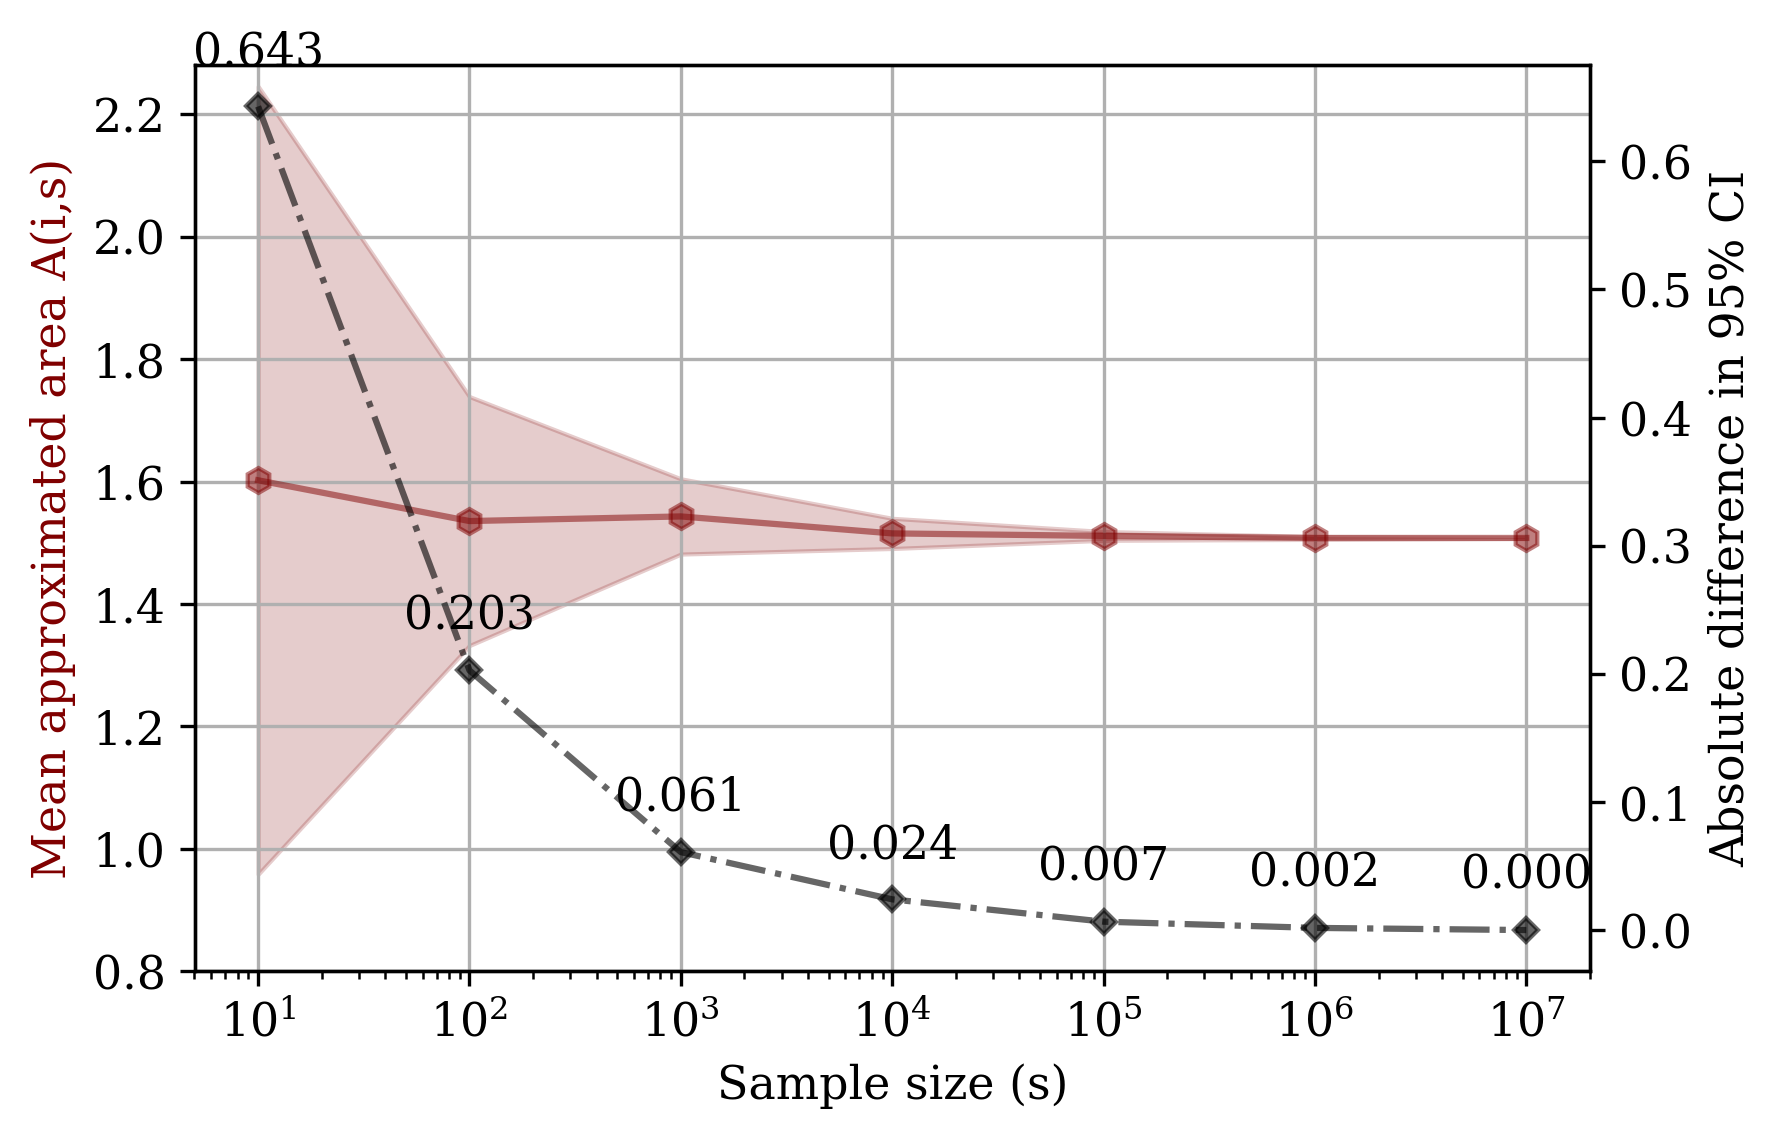

In [55]:
sample_variance_fixed_i(simulation_data = "mc_fixed_i.npz", title = "S_variance_i_fixed.png")

For a fixed $i$, $\lim_{s\to\infty}A_{i,s} = A_i > A_\text{M}$, i.e. we are essentially calculating the area of a superset of the Mandelbrot set, one that includes points that would have met the escape condition after $i$ iterations.

Given a strictly increasing sequence of $i$-values $\{i_1, i_2, \ldots i_n\}$, we would like to pick $i = i_k$ for the smallest $k$ such that $|A_{k+1} - A_{k}|$ is less than some threshold value.

Henceforth, we simulate only the top half of the mandelbrot set.

In [19]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
if not exists("monte_carlo_random_sampling.npz"):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez("monte_carlo_random_sampling.npz", mean_areas, sample_variances)
else:
    save_data = np.load("monte_carlo_random_sampling.npz")
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [14]:
def sample_variance_smaller_i_plotter(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different combinations of i and s values
    
    The range of i values considered are 50, 100, 200, 500, 1000, 200
    
    """
    
    s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_50 = mean_areas[0]
    mean_i_100 = mean_areas[1]
    mean_i_200 = mean_areas[2]
    mean_i_500 = mean_areas[3]
    mean_i_1000 = mean_areas[4]
    mean_i_2000 = mean_areas[5]

    std_i_50 = np.sqrt(sample_variances[0])
    std_i_100 = np.sqrt(sample_variances[1])
    std_i_200 = np.sqrt(sample_variances[2])
    std_i_500 = np.sqrt(sample_variances[3])
    std_i_1000 = np.sqrt(sample_variances[4])
    std_i_2000 = np.sqrt(sample_variances[5])
    
    conf_95_50 = confidence_intervals(sample_variances[0], p = 0.05)
    conf_95_100 = confidence_intervals(sample_variances[1], p = 0.05)
    conf_95_200 = confidence_intervals(sample_variances[2], p = 0.05)
    conf_95_500 = confidence_intervals(sample_variances[3], p = 0.05)
    conf_95_1000 = confidence_intervals(sample_variances[4], p = 0.05)
    conf_95_2000 = confidence_intervals(sample_variances[5], p = 0.05)
    

    plt.plot(s_values, mean_i_50, color = "chocolate", alpha = 0.6, label = "i = 50", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_50 - conf_95_50, mean_i_50 + conf_95_50, alpha = 0.3, color = "chocolate")

    plt.plot(s_values, mean_i_100, color = "maroon", alpha = 0.6, label = "i = 100", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_100 - conf_95_100, mean_i_100 + conf_95_100, alpha = 0.3, color = "maroon")

    plt.plot(s_values, mean_i_200, color = "tomato", alpha = 0.6, label = "i = 200", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_200 - conf_95_200, mean_i_200 + conf_95_200, alpha = 0.3, color = "tomato")

    plt.plot(s_values, mean_i_500, color = "saddlebrown", alpha = 0.6, label = "i = 500", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_500 - conf_95_500, mean_i_500 + conf_95_500, alpha = 0.3, color = "saddlebrown")
    
    plt.plot(s_values, mean_i_1000, color = "purple", alpha = 0.6, label = "i = 1000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_1000 - conf_95_1000, mean_i_1000 + conf_95_1000, alpha = 0.3, color = "purple")

    plt.plot(s_values, mean_i_2000, color = "darkorange", alpha = 0.6, label = "i = 2000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_2000 - conf_95_2000, mean_i_2000 + conf_95_2000, alpha = 0.3, color = "darkorange")

    plt.hlines(1.50659, s_values[0], s_values[-1], label = "$A_M$", linestyles="dashed", linewidth = 1)

    plt.ylim(top=max(mean_i_50)+0.07) 
    plt.xscale('log')
    plt.xlabel("Sample sizes (s)")
    plt.ylabel("Mean approximated area A(i,s)")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    
    plt.savefig(title)
    plt.show() 
    
    
    

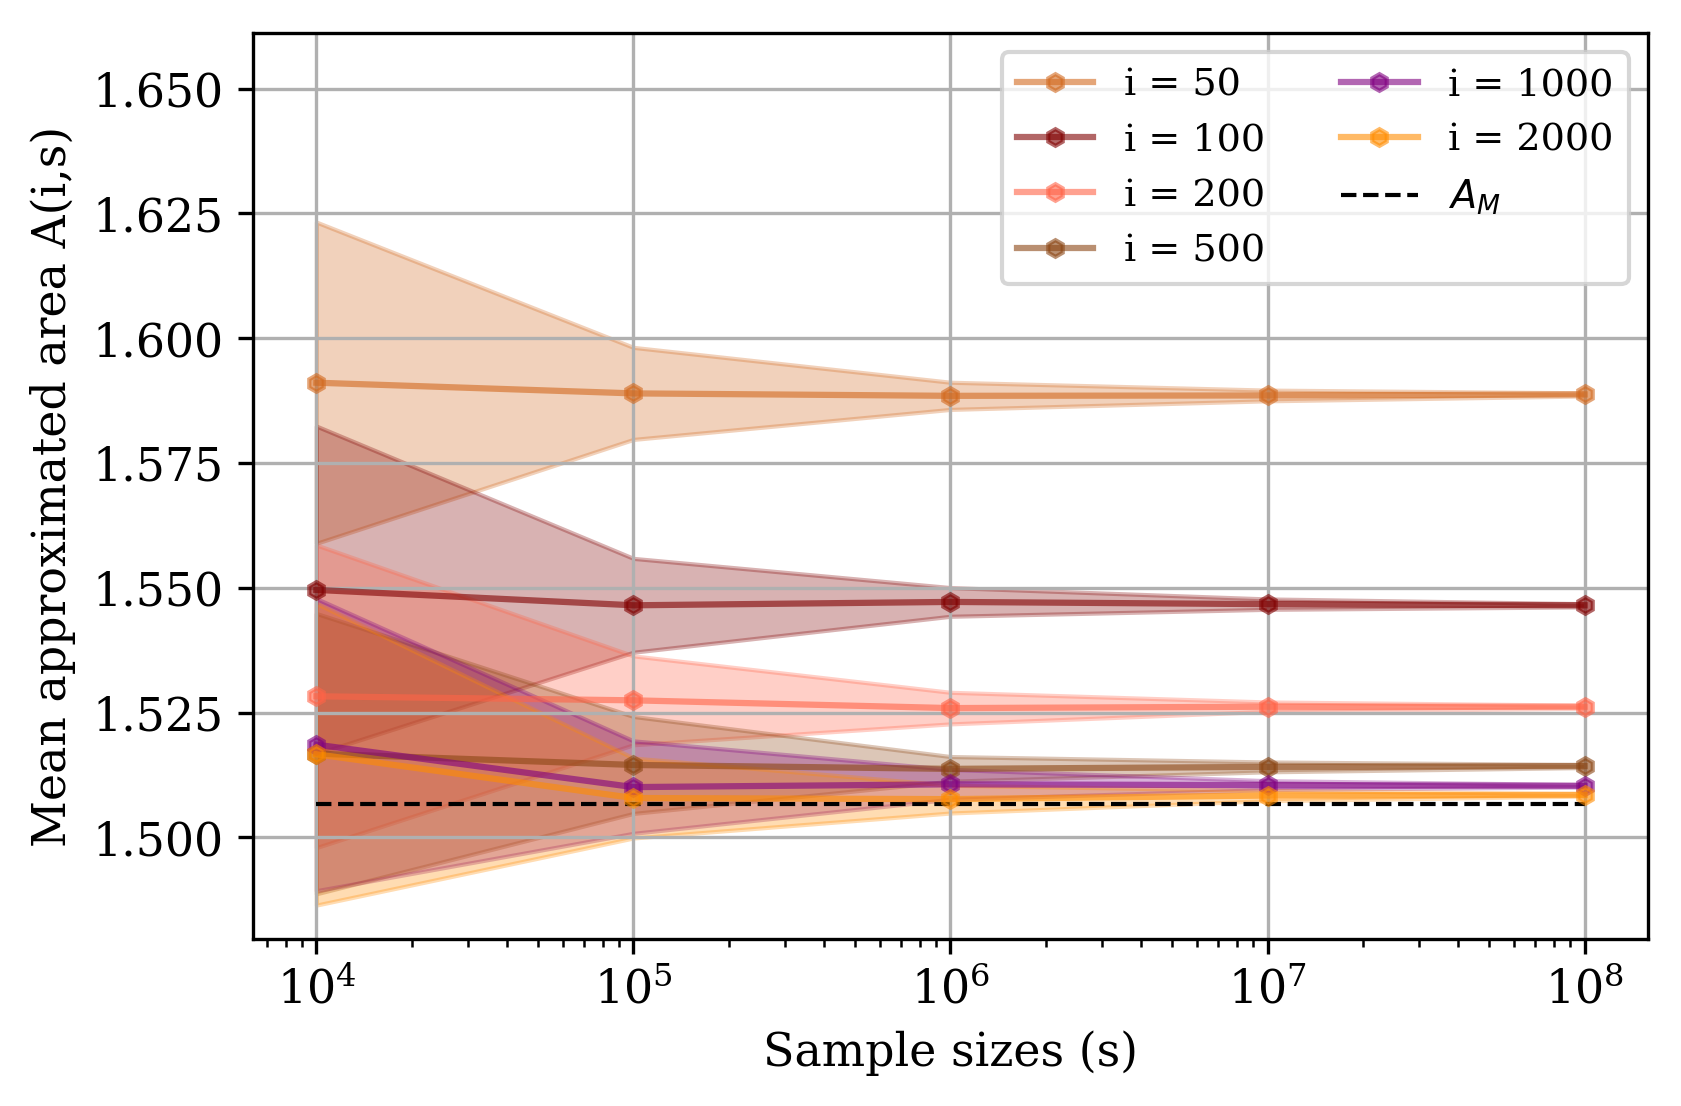

In [15]:
sample_variance_smaller_i_plotter(simulation_data = "monte_carlo_random_sampling.npz", title = "line_plot_samples_random_appendix.png")

In [38]:
i_values = np.array([1000, 2000, 3000, 4000, 5000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
npz_filename = "mc_random_fullsave.npz"
if not exists(npz_filename):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    areas = np.empty((len(i_values),len(s_values), number_of_batches))
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            print(f"Working with i = {i}, s = {s}.")
#             areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas[k][l][j] = est_area
            μ, svar = sample_mean_variance(areas[k][l])
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez(npz_filename, mean_areas, sample_variances, areas) 
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    areas = save_data['arr_2']


In [16]:
def sample_variance_larger_i_plotter(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different combinations of i and s values
    
    The range of i values considered are 1000, 2000, 3000, 4000, 5000
    
    Plots for 1000 and 5000
    

    """
    
    s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_1000 = mean_areas[0]
    mean_i_2000 = mean_areas[1]
    mean_i_3000 = mean_areas[2]
    mean_i_4000 = mean_areas[3]
    mean_i_5000 = mean_areas[4]

    std_i_1000 = np.sqrt(sample_variances[0])
    std_i_2000 = np.sqrt(sample_variances[1])
    std_i_3000 = np.sqrt(sample_variances[2])
    std_i_4000 = np.sqrt(sample_variances[3])
    std_i_5000 = np.sqrt(sample_variances[4])
    
    conf_95_1000 = confidence_intervals(sample_variances[0], p = 0.05)
    conf_95_2000 = confidence_intervals(sample_variances[1], p = 0.05)
    conf_95_3000 = confidence_intervals(sample_variances[2], p = 0.05)
    conf_95_4000 = confidence_intervals(sample_variances[3], p = 0.05)
    conf_95_5000 = confidence_intervals(sample_variances[4], p = 0.05)

    plt.plot(s_values, mean_i_1000, color = "purple", alpha = 0.6, label = "i = 1000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_1000 - conf_95_1000, mean_i_1000 + conf_95_1000, alpha = 0.2, color = "purple")

    #plt.plot(s_values, mean_i_2000, color = "tomato", alpha = 0.6, label = "i = 2000")
    #plt.fill_between(s_values, mean_i_2000 - conf_95_2000, mean_i_2000 + conf_95_2000, alpha = 0.2, color = "tomato")

    #plt.plot(s_values, mean_i_3000, color = "darkgoldenrod", alpha = 0.6, label = "i = 3000", marker = "h", markersize = 4)
    #plt.fill_between(s_values, mean_i_3000 - conf_95_2000, mean_i_3000 + conf_95_2000, alpha = 0.2, color = "darkgoldenrod")

    #plt.plot(s_values, mean_i_4000, color = "orange", alpha = 0.6, label = "i = 4000")
    #plt.fill_between(s_values, mean_i_4000 - conf_95_4000, mean_i_4000 + conf_95_4000, alpha = 0.2, color = "orange")

    plt.plot(s_values, mean_i_5000, color = "darkgreen", alpha = 0.6, label = "i = 5000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_5000 - conf_95_5000, mean_i_5000 + conf_95_5000, alpha = 0.2, color = "darkgreen")

    plt.hlines(1.50659, s_values[0], s_values[-1], label = "$A_M$", linestyles="dashed", linewidth = 1)

    #plt.xlim(10**5, 10**7) 
    plt.xscale('log')
    plt.xlabel("Sample sizes (s)")
    plt.ylabel("Mean approximated area A(i,s)")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small")
    
    plt.savefig(title)
    plt.show() 

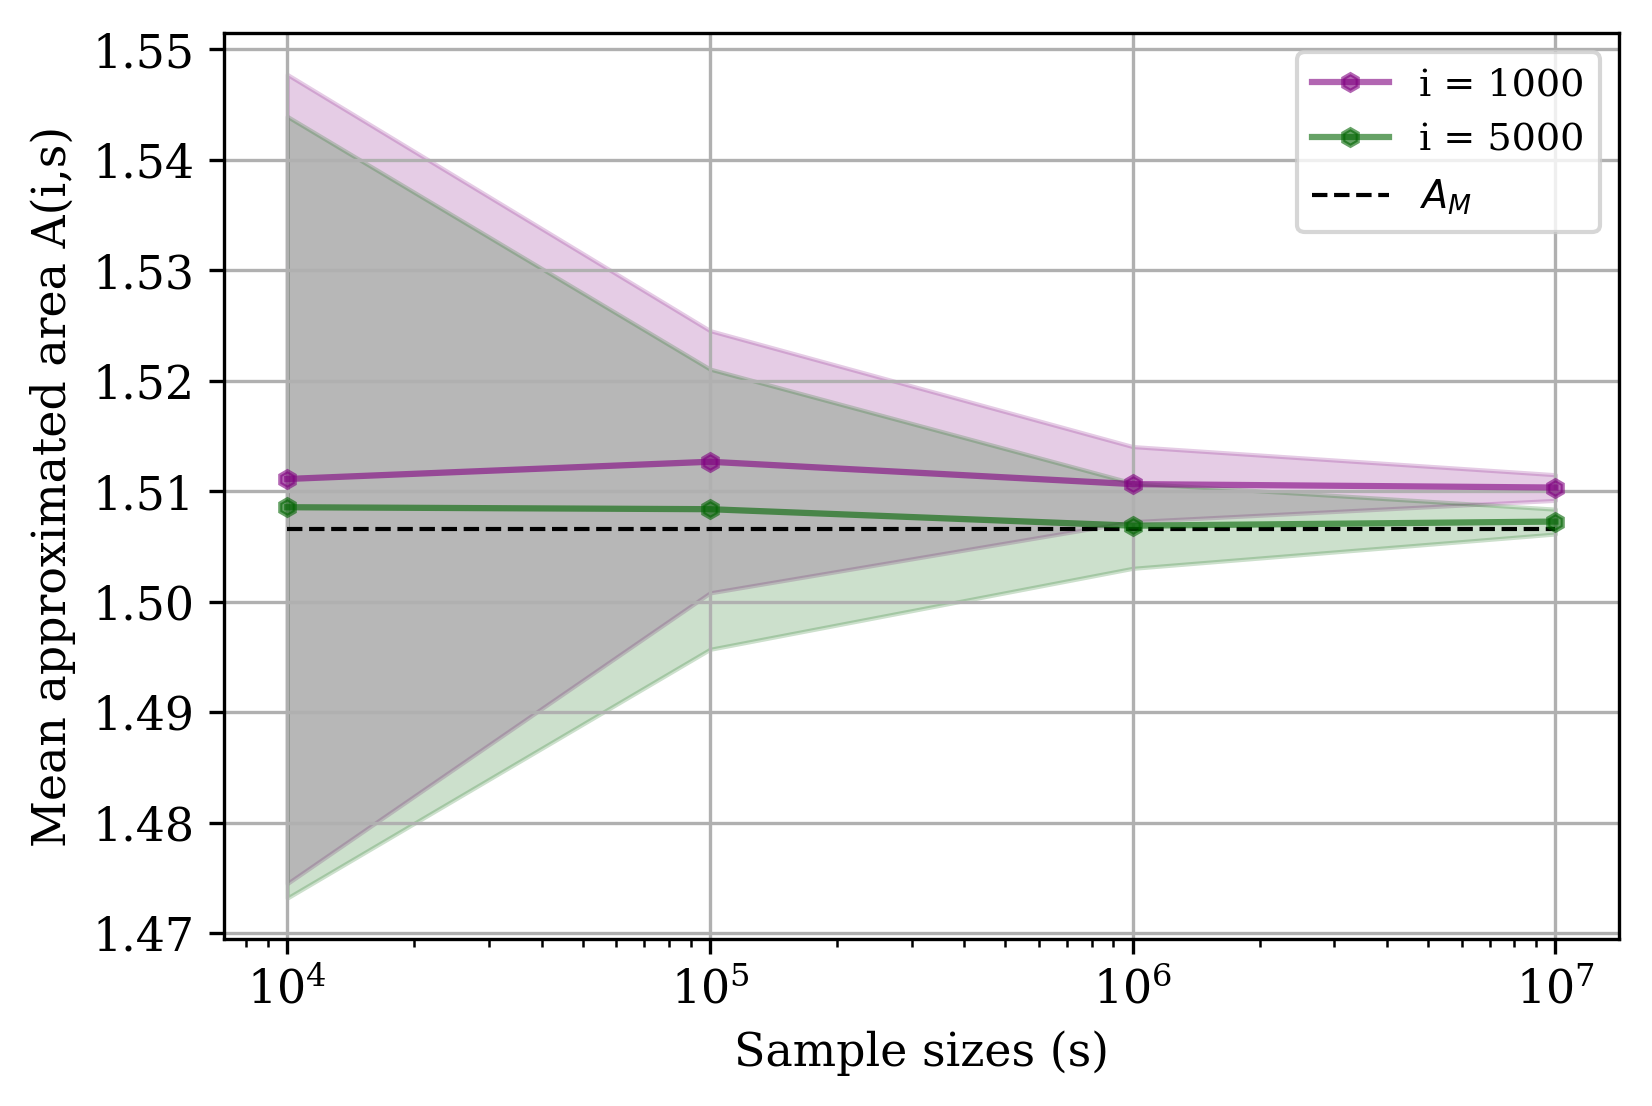

In [17]:
sample_variance_larger_i_plotter(simulation_data = "mc_random_fullsave.npz", title = "line_plot_samples_random.png")

In [50]:
# TODO - seed so that it does not change anymore

def sampling_methods_plotter(n, title):
    
    """
    Plots an example of sample size n for LHC and OS
    
    PRS is hashed out to make the plot more readable

    """
    
    nx = ny = n
    nsq = n**2
    
    #p_r = np.random.random((nsq, 2))
    
    sampler = stats.qmc.LatinHypercube(d=2)
    lhs = sampler.random(nsq)
    
    l_bounds, u_bounds = (0, 0), (1, 1)
    x_randos, y_randos = random_uniform_orthogonal(n, l_bounds, u_bounds)
    
    lhs_corr, _ = stats.pearsonr(lhs[:, 0], lhs[:, 1])
    os_corr, _ = stats.pearsonr(x_randos, y_randos)
    
    print('Pearsons correlation of LHS: %.3f' % lhs_corr)
    print('Pearsons correlation of OS: %.3f' % os_corr)
    
    fig = plt.figure(figsize=(5, 5))
    #plt.scatter(p_r[:, 0], p_r[:, 1], color="b", label="Pure random")
    plt.scatter(lhs[:, 0], lhs[:, 1], s=20, label="LHC", color='darkgreen')
    plt.scatter(x_randos, y_randos, s=20, color="chocolate", label="Orthogonal")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.hlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="darkgreen")
    plt.vlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="darkgreen")
    plt.hlines(np.arange(n)/n, 0, 1, color="chocolate", linewidth = 3)
    plt.vlines(np.arange(n)/n, 0, 1, color="chocolate", linewidth = 3)
    plt.grid(False)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "best")
    plt.savefig(title)
    plt.show()

Pearsons correlation of LHS: 0.131
Pearsons correlation of OS: 0.001


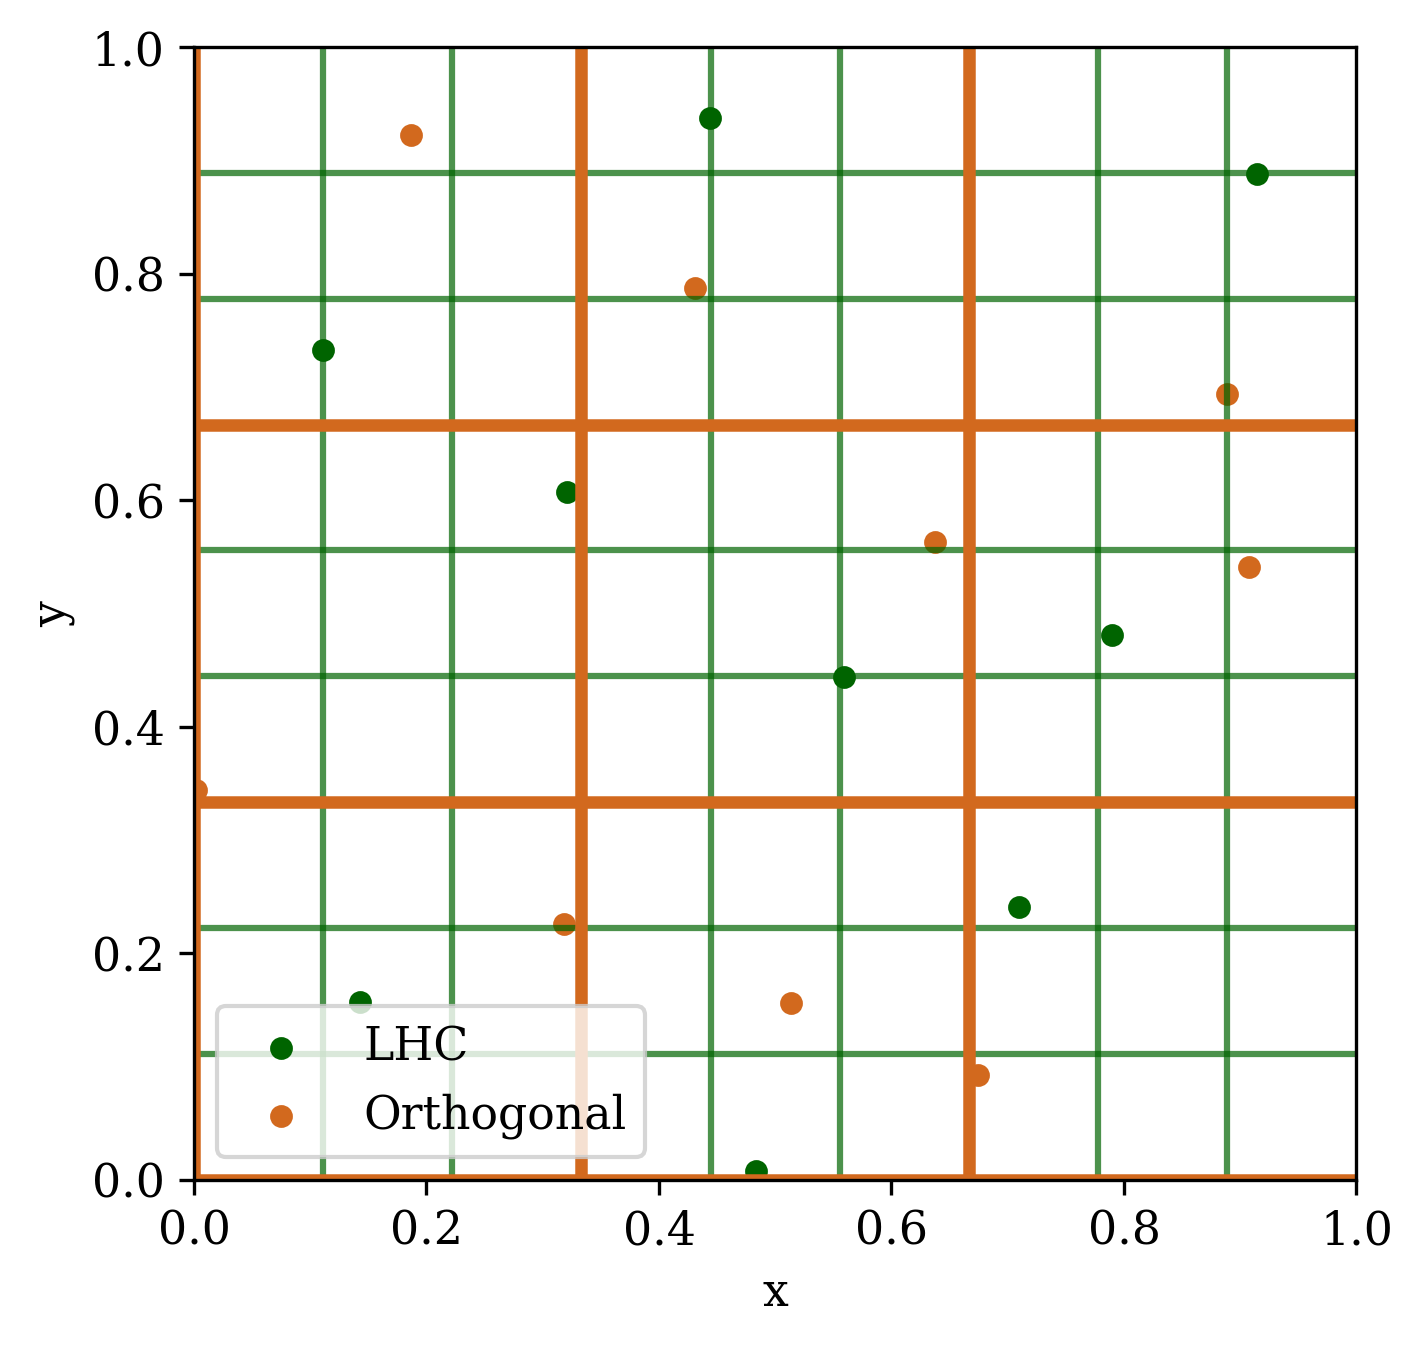

In [51]:
sampling_methods_plotter(n=3, title = "LHS_OS.png")

In [37]:
# Welsh tes

print("Welch test max iterations and i=1000:")
print(stats.ttest_ind(i_1000, i_5000))
print("Welch test max iterations and i=2000:")
print(stats.ttest_ind(i_2000, i_5000))
print("Welch test max iterations and i=3000:")
print(stats.ttest_ind(i_3000, i_5000))
print("Welch test max iterations and i=4000:")
print(stats.ttest_ind(i_4000, i_5000))

Welch test max iterations and i=1000:
Ttest_indResult(statistic=1.9671061846838118, pvalue=0.051998526311467695)
Welch test max iterations and i=2000:
Ttest_indResult(statistic=0.10303214405405932, pvalue=0.9181480031435756)
Welch test max iterations and i=3000:
Ttest_indResult(statistic=0.1796409647119506, pvalue=0.857805355128294)
Welch test max iterations and i=4000:
Ttest_indResult(statistic=0.43357594393617543, pvalue=0.6655493255316912)


In [113]:
# One-sample t-test

print(stats.ttest_1samp(i_1000_s_10_5, 1.5065918849))
print(stats.ttest_1samp(i_1000_s_10_6, 1.5065918849))
print(stats.ttest_1samp(i_2000_s_10_5, 1.5065918849))
print(stats.ttest_1samp(i_2000_s_10_6, 1.5065918849))

NameError: name 'i_1000_s_10_5' is not defined

## Orthogonal Sampling
$s = 3000$ gave us a 95% confidence interval of half-width $ < 10^{-3}$. We expect latin hypercube and orthogonal
sampling methods to give us a significantly smaller confidence interval.

In [46]:
@njit
def run_batch(s, i, re_low, re_high, im_low, im_high, batch_size, batch_generator):
    areas = np.empty(batch_size, dtype = np.float64)
    for batch in range(batch_size):
        samples = batch_generator(s, re_low, re_high, im_low, im_high)
        iter_counts = mandelbrot_mc_default(i, samples)
        area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
        areas[batch] = area
    return areas
    
def run_batch_lhc(s, i, re_low, re_high, im_low, im_high, batch_size, seed = None):
    areas = np.empty(batch_size, dtype = np.float64)
    for batch in range(batch_size):
        samples = create_batch_lhc(s, re_low, re_high, im_low, im_high, seed = seed)
        iter_counts = mandelbrot_mc_default(i, samples)
        areas[batch] = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
    return areas

In [41]:
area_from_iter_counts?

In [42]:
s = 10**8
i_values = np.array([3000,4000,5000])

re_low, re_high = -2, 1
im_low, im_high = 0, 1.5

number_of_batches = 50

npz_filename = "mc_orthogonal.npz"
areas = []
if not exists(npz_filename):
    for i in i_values:
        print(f"Working with i = {i}")
        areas.append(run_batch(s, i, re_low, re_high, im_low, im_high, number_of_batches, create_batch_orthogonal))
    stats = [sample_mean_variance(batch) for batch in areas]
    mean_areas = np.array([stat[0] for stat in stats])
    sample_variances = np.array([stat[1] for stat in stats])
    areas = np.array(areas)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    keys = [f"arr_{i}" for i in range(3)]
    mean_areas, sample_variances, areas = (save_data[key] for key in keys)

## Latin Hypercube Sampling

In [43]:
s = 10**8
i_values = np.array([3000,4000,5000])

re_low, re_high = -2, 1
im_low, im_high = 0, 1.5

number_of_batches = 50

npz_filename = "mc_lhc.npz"
areas = []
if not exists(npz_filename):
    for i in i_values:
        areas.append(run_batch_lhc(s, i, re_low, re_high, im_low, im_high, number_of_batches))
    statistics = [sample_mean_variance(batch) for batch in areas]
    mean_areas = np.array([stat[0] for stat in statistics])
    sample_variances = np.array([stat[1] for stat in statistics])
    areas = np.array(areas)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    keys = [f"arr_{i}" for i in range(3)]
    mean_areas, sample_variances, areas = (save_data[key] for key in keys)

## Comparison between PRS, LHC, and OS
Fix $i, s$ and compare for different sampling methods

In [25]:
i = 1000
s = 10**4 # 
number_of_batches = 300 # TODO: decide value from previous cell's results
# TODO: change name of data 400 good

npz_filename = "3_sampling_methods_one_run_10_4_300.npz"

re_low, re_high = -2., 1.
im_low, im_high = 0., 1.5

generators = [create_batch_uniform, create_batch_orthogonal, create_batch_lhc]

if not exists(npz_filename):
    areas = np.empty((3,number_of_batches))
    mean_areas = mean_areas = np.empty(3)
    sample_variances = np.empty(3)

    
    for k, method in enumerate(generators):
        for b in range(number_of_batches):
            samples = method(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas[k][b] = area
        μ, σsq = sample_mean_variance(areas[k])
        mean_areas[k] = μ
        sample_variances[k] = σsq
       
    print(mean_areas * 2)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    indices = (f"arr_{i}" for i in range(3))
    mean_areas, sample_variances, areas = (save_data[i] for i in indices)

[1.508589 1.509972 1.511037]


In [60]:

def sampling_methods_histogram(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_2']*2
    
    df = pd.DataFrame((areas), index=["PS", "OS", "LHS"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['maroon', 'pumpkin', 'olive green'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
    sns.axes_style("whitegrid")
    fig = sns.displot(df_t, bins = 40, kde = True, legend = False, palette=palette) #husl"CMRmap_r"
    
    plt.xlabel("$A_M$")
    
    plt.legend(loc = 1, title = "Sampling methods", labels= ["LHS", "OS", "RS"])
    
    
    plt.savefig(title)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


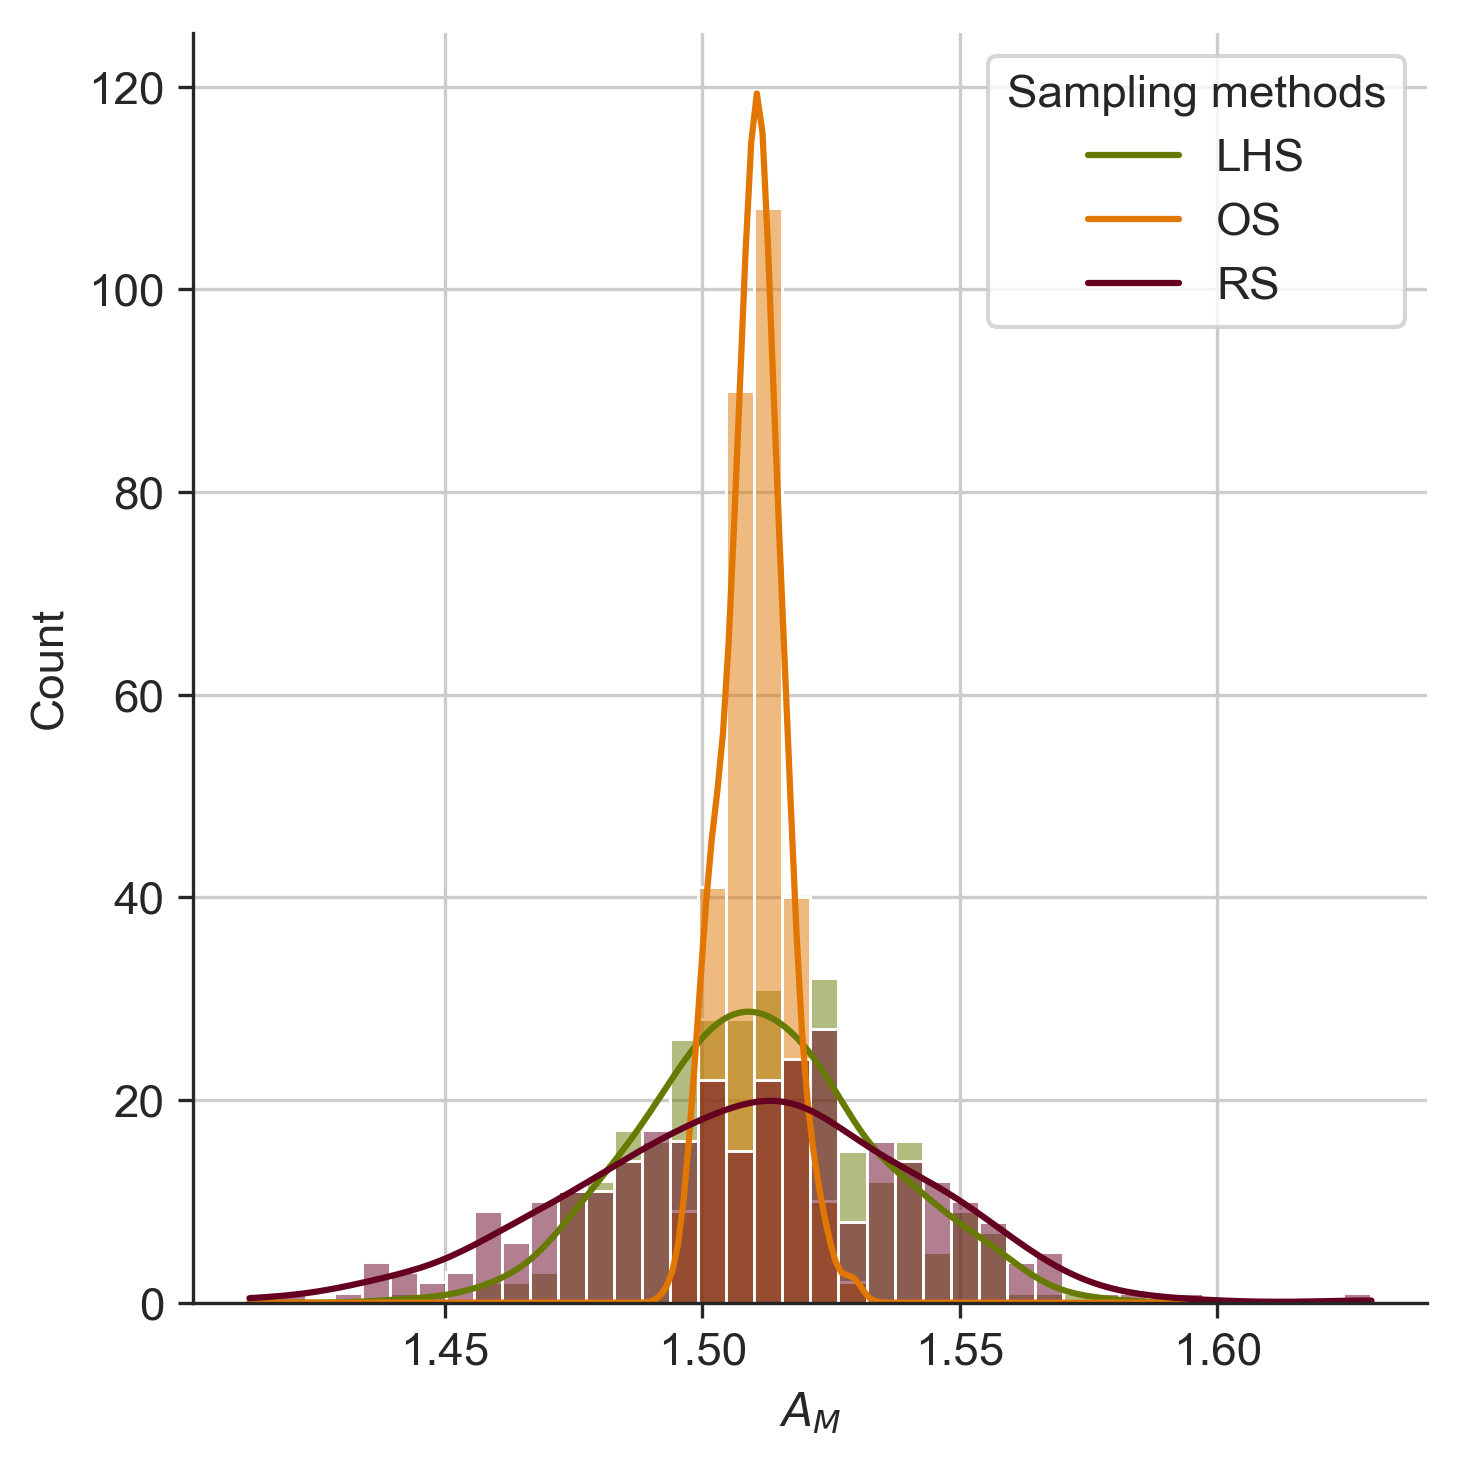

In [61]:
sampling_methods_histogram(simulation_data = "3_sampling_methods_one_run_10_4_300.npz", title = "Three_sampling_methods_histogram.png")

In [62]:
def sampling_methods_boxplot(simulation_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_2']*2
    
    palette = sns.xkcd_palette(['maroon', 'pumpkin', 'olive green'])
    
    df = pd.DataFrame(np.transpose(areas), columns = ["PS", "OS", "LHS"])
    
    fig = sns.boxplot(data=df, palette=palette)
    
    plt.xlabel("Sampling Methods")
    plt.ylabel("Mean approximated area $A_{i,s}$")
    plt.savefig(title)

In [66]:
def sampling_methods_violinplot(simulation_data, title):
    
    """"
    Plots boxplot from simualation data 
    using seaborn's `violinplot`
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_2']*2
    
    palette = sns.xkcd_palette(['maroon', 'pumpkin', 'olive green'])
  
    
    df = pd.DataFrame(np.transpose(areas), columns = ["PS", "OS", "LHS"])
    
    fig = sns.violinplot(data=df, palette=palette)
    
    plt.xlabel("Sampling Methods")
    plt.ylabel("Mean approximated area $A_{i,s}")
    plt.savefig(title)

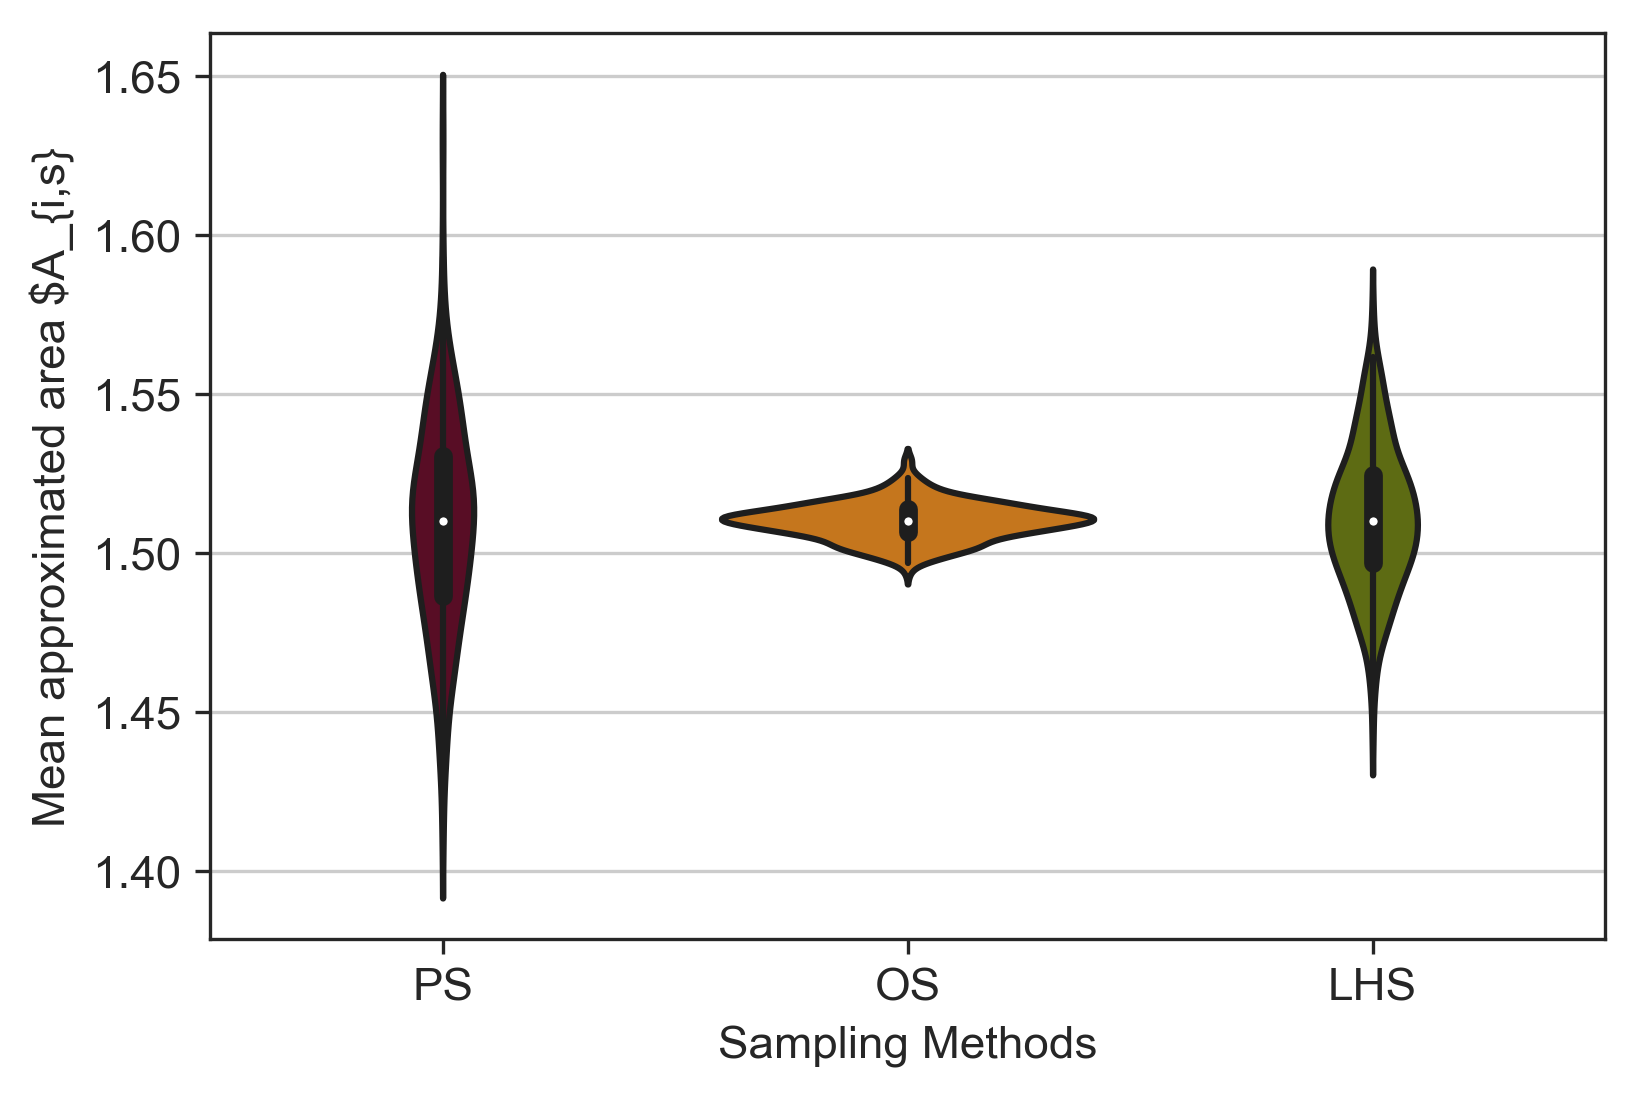

In [67]:
sampling_methods_violinplot(simulation_data = "3_sampling_methods_one_run_10_4_300.npz", title = "Violinplot.png")

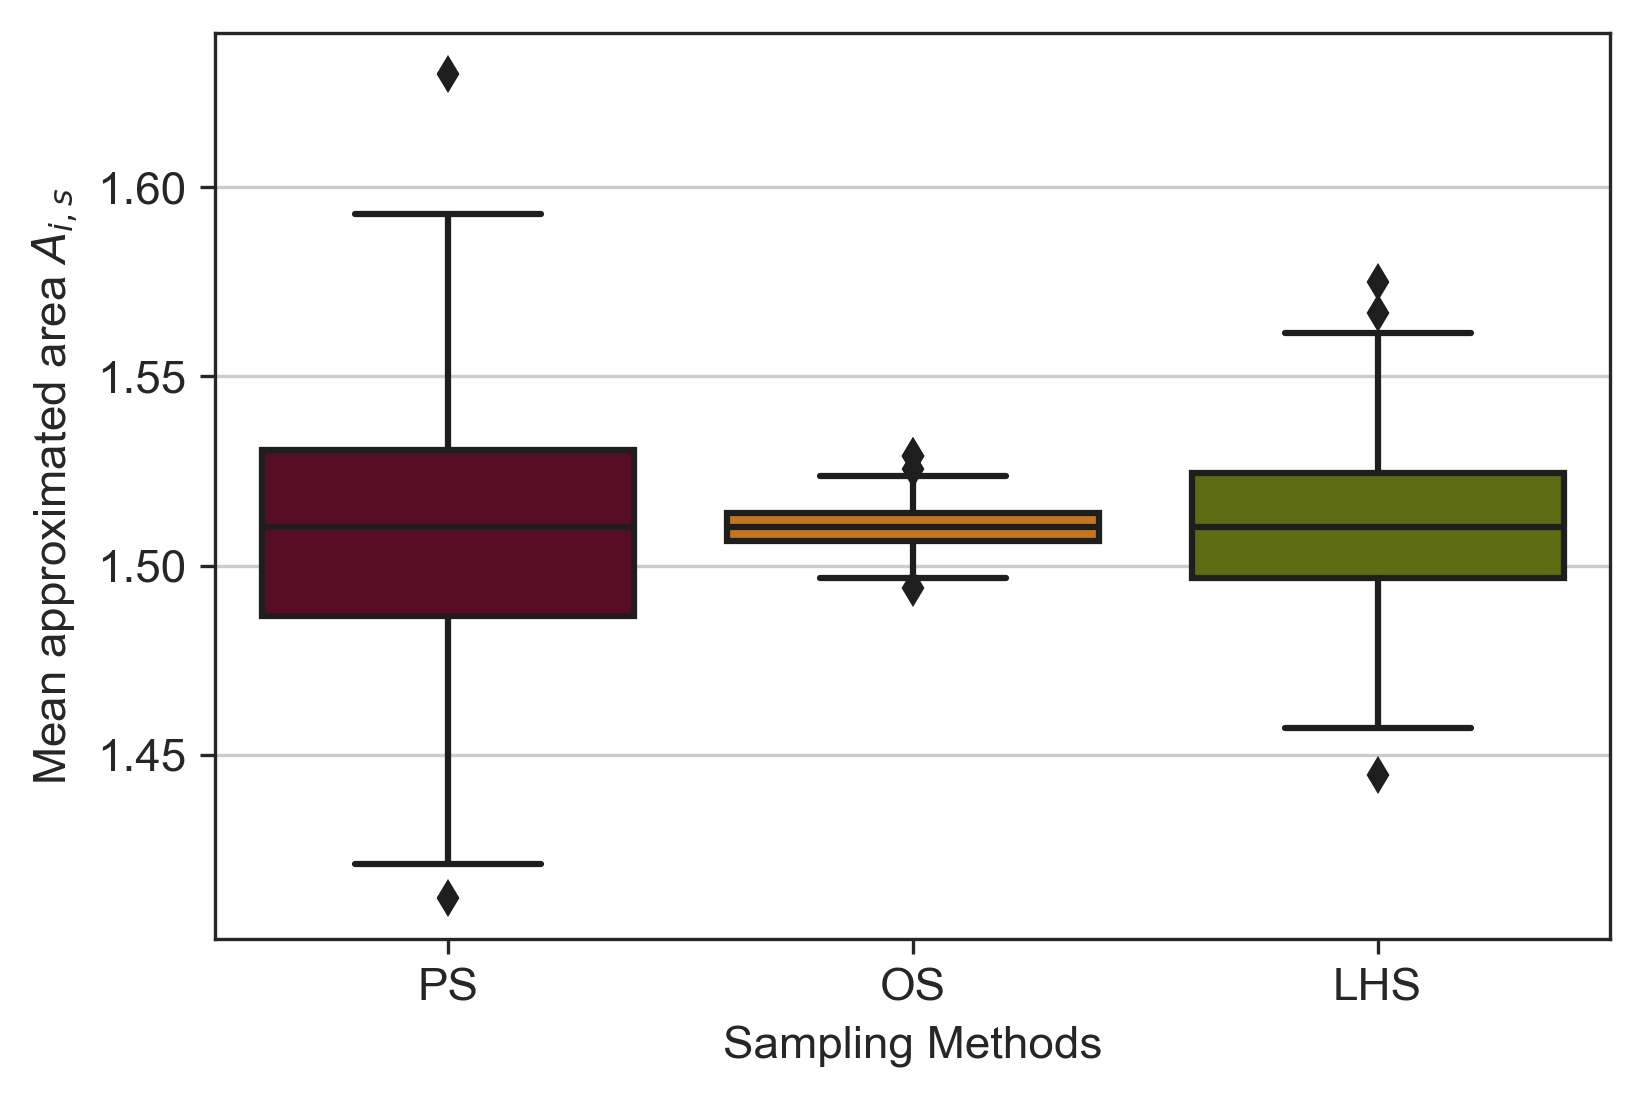

In [65]:
sampling_methods_boxplot(simulation_data = "3_sampling_methods_one_run_10_4_300.npz", title = "Boxplots.png")

In [ ]:
def f_test(x, y, alt="two_sided"):
    """
    Calculates the F-test.
    :param x: The first group of data
    :param y: The second group of data
    :param alt: The alternative hypothesis, one of "two_sided" (default), "greater" or "less"
    :return: a tuple with the F statistic value and the p-value.
    """
    df1 = len(x) - 1
    df2 = len(y) - 1
    f = x.var() / y.var()
    if alt == "greater":
        p = 1.0 - st.f.cdf(f, df1, df2)
    elif alt == "less":
        p = st.f.cdf(f, df1, df2)
    else:
        # two-sided by default
        # Crawley, the R book, p.355
        p = 2.0*(1.0 - st.f.cdf(f, df1, df2))
    return f, p

In [145]:
sns.xkcd_palette(['yellow orange', 'maroon', 'dark grass green'])

[(0.9882352941176471, 0.6901960784313725, 0.00392156862745098),
 (0.396078431372549, 0.0, 0.12941176470588237),
 (0.2196078431372549, 0.5019607843137255, 0.01568627450980392)]